# **Redes Neurais**
## **Modelo 1 - Rede MLP**

- Tales Miguel
- RA: 140247

- Professor Dr. Marcos G. Quiles

### **Instruções**

- Selecionar dois datasets (não triviais)
    - Um dataset para classificação
    - Um dataset para regressão

- Separar em treino/validação/teste
- Treinar modelos MLP para os dois problemas

- Considerar:
    - Diferentes topologias (>=5 topologias, variar número de camadas)
    - Usar o algoritmo original SGD (não usar algoritmos otimizados, e.g. ADAM)
    - Avaliar o impacto do uso do Momentum
    - Avaliar o impacto do uso da regularização (i.e. L2)

- Ilustrar graficamente a evolução do treinamento (treino/validação).
- Confeccionar um relatório (reprodutível) contendo os experimentos e resultados

### **1. Datasets escolhidos**

#### **Classificação: MNIST**
**Fonte**: `keras.datasets.mnist` | [Original: Yann LeCun](http://yann.lecun.com/exdb/mnist/)
- Ano: 1998
- Samples: 70.000 (60k treino + 10k teste)
- Features: 784 (28x28 pixels)
- Target: 10 classes (dígitos 0-9)

#### **Regressão: California Housing**  
**Fonte**: `sklearn.datasets.fetch_california_housing` | [Census 1990](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)
- Ano: 1997
- Samples: 20.640
- Features: 8
    - MedInc - Median income in block group
    - HouseAge - Median house age in block group
    - AveRooms - Average number of rooms per household
    - AveBedrms - Average number of bedrooms per household
    - Population - Block group population
    - AveOccup - Average number of household members
    - Latitude - Block group latitude
    - Longitude - Block group longitude
- Target: MedHouseVal (valor mediano das casas)

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import History
from keras.datasets import mnist
from keras.utils import plot_model

np.random.seed(42)
tf.random.set_seed(42)          


## **2. Classificação - MNIST**

### **2.1. Carregamento e Pré-processamento**
Carregamento do MNIST, normalização dos pixels (0-1) e preparação dos dados para treinamento.

Foram escolhidos 48000 dados para Treino, 12000 para Validação, e 10000 para Teste.

In [3]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

X_train_mnist = X_train_mnist.reshape(X_train_mnist.shape[0], -1).astype('float32') / 255.0
X_test_mnist = X_test_mnist.reshape(X_test_mnist.shape[0], -1).astype('float32') / 255.0

X_train_mnist, X_val_mnist, y_train_mnist, y_val_mnist = train_test_split(
    X_train_mnist, y_train_mnist, test_size=0.2, random_state=42, stratify=y_train_mnist
)

print(f"Train: {X_train_mnist.shape}, Val: {X_val_mnist.shape}, Test: {X_test_mnist.shape}")
print(f"Pixel range: [{X_train_mnist.min():.1f}, {X_train_mnist.max():.1f}]")
print(f"Classes: {np.unique(y_train_mnist)}")

Train: (48000, 784), Val: (12000, 784), Test: (10000, 784)
Pixel range: [0.0, 1.0]
Classes: [0 1 2 3 4 5 6 7 8 9]


### **2.2. Visualização dos Dados**
Análise visual dos dígitos e distribuição das classes.

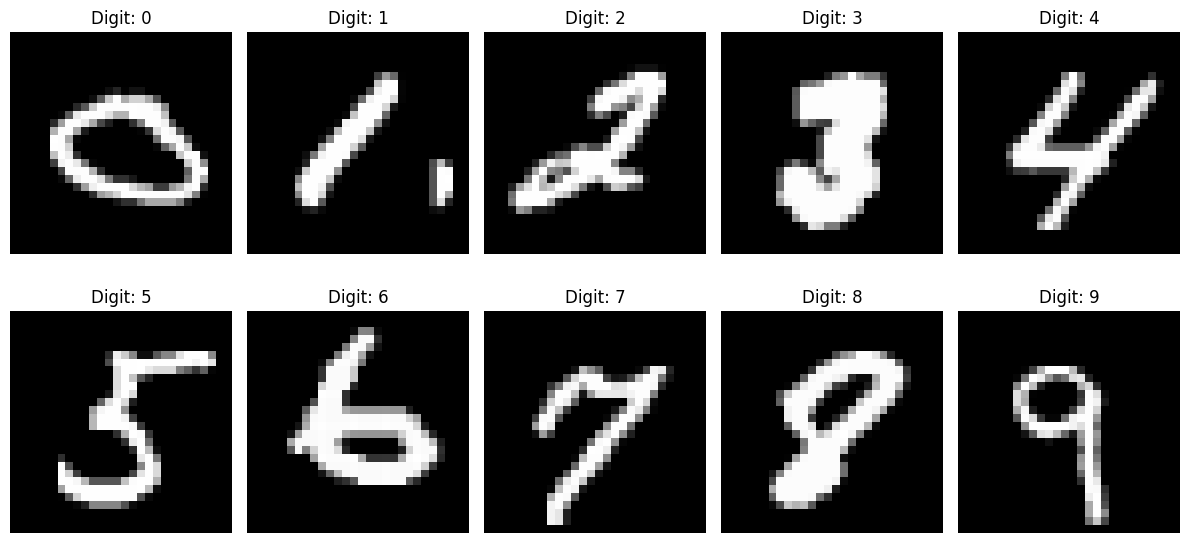

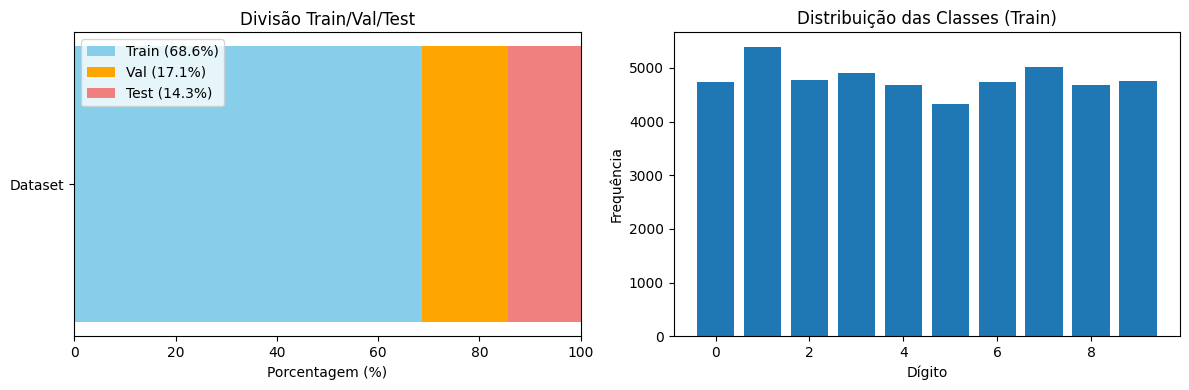

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    idx = np.where(y_train_mnist == i)[0][0]
    img = X_train_mnist[idx].reshape(28, 28)
    axes[i//5, i%5].imshow(img, cmap='gray')
    axes[i//5, i%5].set_title(f'Digit: {i}')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 4))

unique, counts = np.unique(y_train_mnist, return_counts=True)
ax1.bar(unique, counts)
ax1.set_title('Distribuição das Classes (Train)')
ax1.set_xlabel('Dígito')
ax1.set_ylabel('Frequência')

total_samples = len(X_train_mnist) + len(X_val_mnist) + len(X_test_mnist)
train_pct = len(X_train_mnist) / total_samples * 100
val_pct = len(X_val_mnist) / total_samples * 100
test_pct = len(X_test_mnist) / total_samples * 100

ax2.barh(['Dataset'], [train_pct], left=0, label=f'Train ({train_pct:.1f}%)', color='skyblue')
ax2.barh(['Dataset'], [val_pct], left=train_pct, label=f'Val ({val_pct:.1f}%)', color='orange')
ax2.barh(['Dataset'], [test_pct], left=train_pct+val_pct, label=f'Test ({test_pct:.1f}%)', color='lightcoral')
ax2.set_xlabel('Porcentagem (%)')
ax2.set_title('Divisão Train/Val/Test')
ax2.legend()
ax2.set_xlim(0, 100)

plt.tight_layout()
plt.show()

### **2.3. Configuração dos Experimentos**
5 topologias diferentes com análise de Stochastic Gradient Descent (SGD), Momentum e Regularização L2.

Serão feitos **9** experimentos:

- 1 Camada:
    - 4 neurônios: [4] → 10
    - 16 neurônios: [16] → 10
    - 64 neurônios: [64] → 10

- 2 Camadas:
    - [4, 4] → 10
    - [16, 4] → 10
    - [4, 16] → 10 
    - [32, 64] → 10
    - [64, 32] → 10

- 3 Camadas:
    - [64, 32, 16] → 10

In [5]:
topologies = [
    ("1 camada, 4 neurônios", [4]),
    ("1 camada, 16 neurônios", [16]),
    ("1 camada, 64 neurônios", [64]),
    ("2 camadas, 4-4", [4, 4]),
    ("2 camadas, 16-4", [16, 4]),
    ("2 camadas, 4-16", [4, 16]),
    ("2 camadas, 32-64", [32, 64]),
    ("2 camadas, 64-32", [64, 32]),
    ("3 camadas, 64-32-16", [64, 32, 16])
]

configurations = [
    ("SGD", {"use_momentum": False, "use_l2": False}),
    ("SGD + Momentum", {"use_momentum": True, "use_l2": False}),
    ("SGD + L2", {"use_momentum": False, "use_l2": True}),
    ("SGD + Momentum + L2", {"use_momentum": True, "use_l2": True})
]

### **2.4. Função para Criar e Treinar Modelos**
Função auxiliar para criação de MLPs com diferentes configurações

50 épocas fixas.

- Loss:
  - Cross Entropy.

- Função de ativação:
  - ReLu para camadas Densas.
  - Softmax na saída (10 neurônios).

In [6]:
def create_mlp_model(layers, use_momentum=False, use_l2=False):
    model = Sequential()
    
    for i, neurons in enumerate(layers):
        if i == 0:
            if use_l2:
                model.add(Dense(neurons, activation='relu', input_shape=(784,), 
                               kernel_regularizer=l2(0.001)))
            else:
                model.add(Dense(neurons, activation='relu', input_shape=(784,)))
        else:
            if use_l2:
                model.add(Dense(neurons, activation='relu', 
                               kernel_regularizer=l2(0.001)))
            else:
                model.add(Dense(neurons, activation='relu'))
    
    model.add(Dense(10, activation='softmax'))
    
    if use_momentum:
        optimizer = SGD(learning_rate=0.01, momentum=0.9)
    else:
        optimizer = SGD(learning_rate=0.01)
    
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

def train_and_evaluate(model, model_name, epochs=50):
    import time
    start_time = time.time()
    
    history = model.fit(X_train_mnist, y_train_mnist,
                       validation_data=(X_val_mnist, y_val_mnist),
                       epochs=epochs, batch_size=128, verbose=0)
    
    training_time = time.time() - start_time

    val_loss = min(history.history['val_loss'])
    val_acc = max(history.history['val_accuracy'])
    
    return history, val_acc, val_loss, training_time

### **2.5. Todas as Topologias - Comparação**
Treinamento de todas as 9 topologias com SGD simples para comparação.

In [7]:
all_results = []

for i, (topo_name, layers) in enumerate(topologies, 1):
    
    config = {"use_momentum": False, "use_l2": False}
    model = create_mlp_model(layers, **config)
    history, val_acc, val_loss, training_time = train_and_evaluate(model, f"topo_{i}")
    
    result = {
        'name': topo_name,
        'layers': layers,
        'history': history,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'training_time': training_time,
        'model': model,
        'topology_id': i
    }
    
    all_results.append(result)
    
    print(f"Topologia {i}: {topo_name}")
    print(f"  Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f} | Tempo: {training_time:.2f}s\n")

print("Treinamento concluído!")

/home/tales/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1760563113.358718   36892 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1180 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-10-15 18:18:33.899688: I external/local_xla/xla/service/service.cc:163] XLA service 0x7aaf6c004680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-15 18:18:33.899705: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-10-15 18:18:33.912271: I tensorflow/compiler/mlir/tensorflo

Topologia 1: 1 camada, 4 neurônios
  Val Acc: 0.8255 | Val Loss: 0.5928 | Tempo: 21.11s

Topologia 2: 1 camada, 16 neurônios
  Val Acc: 0.9278 | Val Loss: 0.2547 | Tempo: 18.47s



2025-10-15 18:19:13.548238: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-10-15 18:19:14.611558: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 4 bytes spill stores, 4 bytes spill loads



Topologia 3: 1 camada, 64 neurônios
  Val Acc: 0.9449 | Val Loss: 0.1934 | Tempo: 20.03s

Topologia 4: 2 camadas, 4-4
  Val Acc: 0.8512 | Val Loss: 0.5263 | Tempo: 20.24s

Topologia 5: 2 camadas, 16-4
  Val Acc: 0.8888 | Val Loss: 0.3972 | Tempo: 20.00s

Topologia 6: 2 camadas, 4-16
  Val Acc: 0.8679 | Val Loss: 0.4508 | Tempo: 21.51s



2025-10-15 18:20:35.309048: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-15 18:20:35.309083: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-15 18:20:35.643863: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_184', 8 bytes spill stores, 8 bytes spill loads

2025-10-15 18:20:35.701581: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

Topologia 7: 2 camadas, 32-64
  Val Acc: 0.9528 | Val Loss: 0.1654 | Tempo: 21.77s



2025-10-15 18:20:57.086357: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-15 18:20:57.086371: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-15 18:20:57.383528: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170', 304 bytes spill stores, 304 bytes spill loads

2025-10-15 18:20:57.457895: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning 

Topologia 8: 2 camadas, 64-32
  Val Acc: 0.9557 | Val Loss: 0.1539 | Tempo: 22.74s

Topologia 9: 3 camadas, 64-32-16
  Val Acc: 0.9617 | Val Loss: 0.1324 | Tempo: 21.39s

Treinamento concluído!


### **2.6. Análise Comparativa das Topologias**
Identificação da melhor e pior topologia para análise detalhada.


MELHOR: 3 camadas, 64-32-16 - Val Acc: 0.9617

PIOR: 1 camada, 4 neurônios - Val Acc: 0.8255


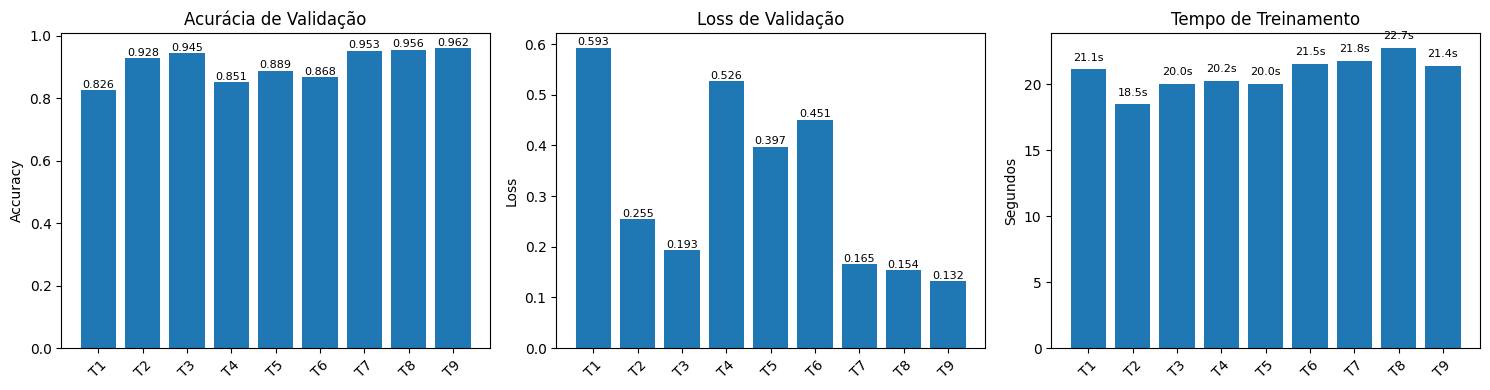

In [8]:
results_df = pd.DataFrame([{
    'Topologia': r['name'],
    'Val_Accuracy': r['val_acc'],
    'Val_Loss': r['val_loss'], 
    'Tempo_Treino': r['training_time'],
    'ID': r['topology_id']
} for r in all_results])

results_df = results_df.sort_values('Val_Accuracy', ascending=False)

best_topology = all_results[results_df.iloc[0]['ID'] - 1]
worst_topology = all_results[results_df.iloc[-1]['ID'] - 1]

print(f"\nMELHOR: {best_topology['name']} - Val Acc: {best_topology['val_acc']:.4f}")
print(f"\nPIOR: {worst_topology['name']} - Val Acc: {worst_topology['val_acc']:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Acurácia
bars1 = axes[0].bar(range(len(all_results)), [r['val_acc'] for r in all_results])
axes[0].set_title('Acurácia de Validação')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(len(all_results)))
axes[0].set_xticklabels([f"T{i+1}" for i in range(len(all_results))], rotation=45)

for bar, value in zip(bars1, [r['val_acc'] for r in all_results]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)

# Loss
bars2 = axes[1].bar(range(len(all_results)), [r['val_loss'] for r in all_results])
axes[1].set_title('Loss de Validação')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(len(all_results)))
axes[1].set_xticklabels([f"T{i+1}" for i in range(len(all_results))], rotation=45)

for bar, value in zip(bars2, [r['val_loss'] for r in all_results]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)

# Tempo
bars3 = axes[2].bar(range(len(all_results)), [r['training_time'] for r in all_results])
axes[2].set_title('Tempo de Treinamento')
axes[2].set_ylabel('Segundos')
axes[2].set_xticks(range(len(all_results)))
axes[2].set_xticklabels([f"T{i+1}" for i in range(len(all_results))], rotation=45)

for bar, value in zip(bars3, [r['training_time'] for r in all_results]):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{value:.1f}s', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

- Training loss: Como o modelo está aprendendo nos dados de treino
- Validation loss: Como o modelo generaliza para dados ainda não vistos
- Gap entre train/val loss: Pode indicar overfitting (se muito grande)

### **2.7. Análise Detalhada: Melhor Topologia**
Variação de SGD, Momentum e L2 na melhor topologia.

In [9]:
best_detailed_results = []
layers = best_topology['layers']

sgd_simple_result = {
    'config': 'SGD',
    'history': best_topology['history'],
    'val_acc': best_topology['val_acc'],
    'val_loss': best_topology['val_loss'],
    'training_time': best_topology['training_time'],
    'model': best_topology['model']
}
best_detailed_results.append(sgd_simple_result)
print(f"Reutilizando resultado SGD: Val Acc: {sgd_simple_result['val_acc']:.4f} | Val Loss: {sgd_simple_result['val_loss']:.4f}")

# Treinar apenas as configurações restantes
remaining_configs = [
    ("SGD + Momentum", {"use_momentum": True, "use_l2": False}),
    ("SGD + L2", {"use_momentum": False, "use_l2": True}),
    ("SGD + Momentum + L2", {"use_momentum": True, "use_l2": True})
]

for config_name, config in remaining_configs:
    print(f"Treinando: {config_name}")
    
    model = create_mlp_model(layers, **config)
    history, val_acc, val_loss, training_time = train_and_evaluate(model, f"best_{config_name}")
    
    best_detailed_results.append({
        'config': config_name,
        'history': history,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'training_time': training_time,
        'model': model
    })
    
    print(f"  Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f} | Tempo: {training_time:.2f}s")

Reutilizando resultado SGD: Val Acc: 0.9617 | Val Loss: 0.1324
Treinando: SGD + Momentum


/home/tales/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Val Acc: 0.9728 | Val Loss: 0.1210 | Tempo: 23.48s
Treinando: SGD + L2


2025-10-15 18:22:04.949072: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-15 18:22:05.162138: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_307', 8 bytes spill stores, 8 bytes spill loads

2025-10-15 18:22:05.269239: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_307', 152 bytes spill stores, 152 bytes spill loads



  Val Acc: 0.9597 | Val Loss: 0.2853 | Tempo: 20.62s
Treinando: SGD + Momentum + L2
  Val Acc: 0.9684 | Val Loss: 0.1870 | Tempo: 21.54s


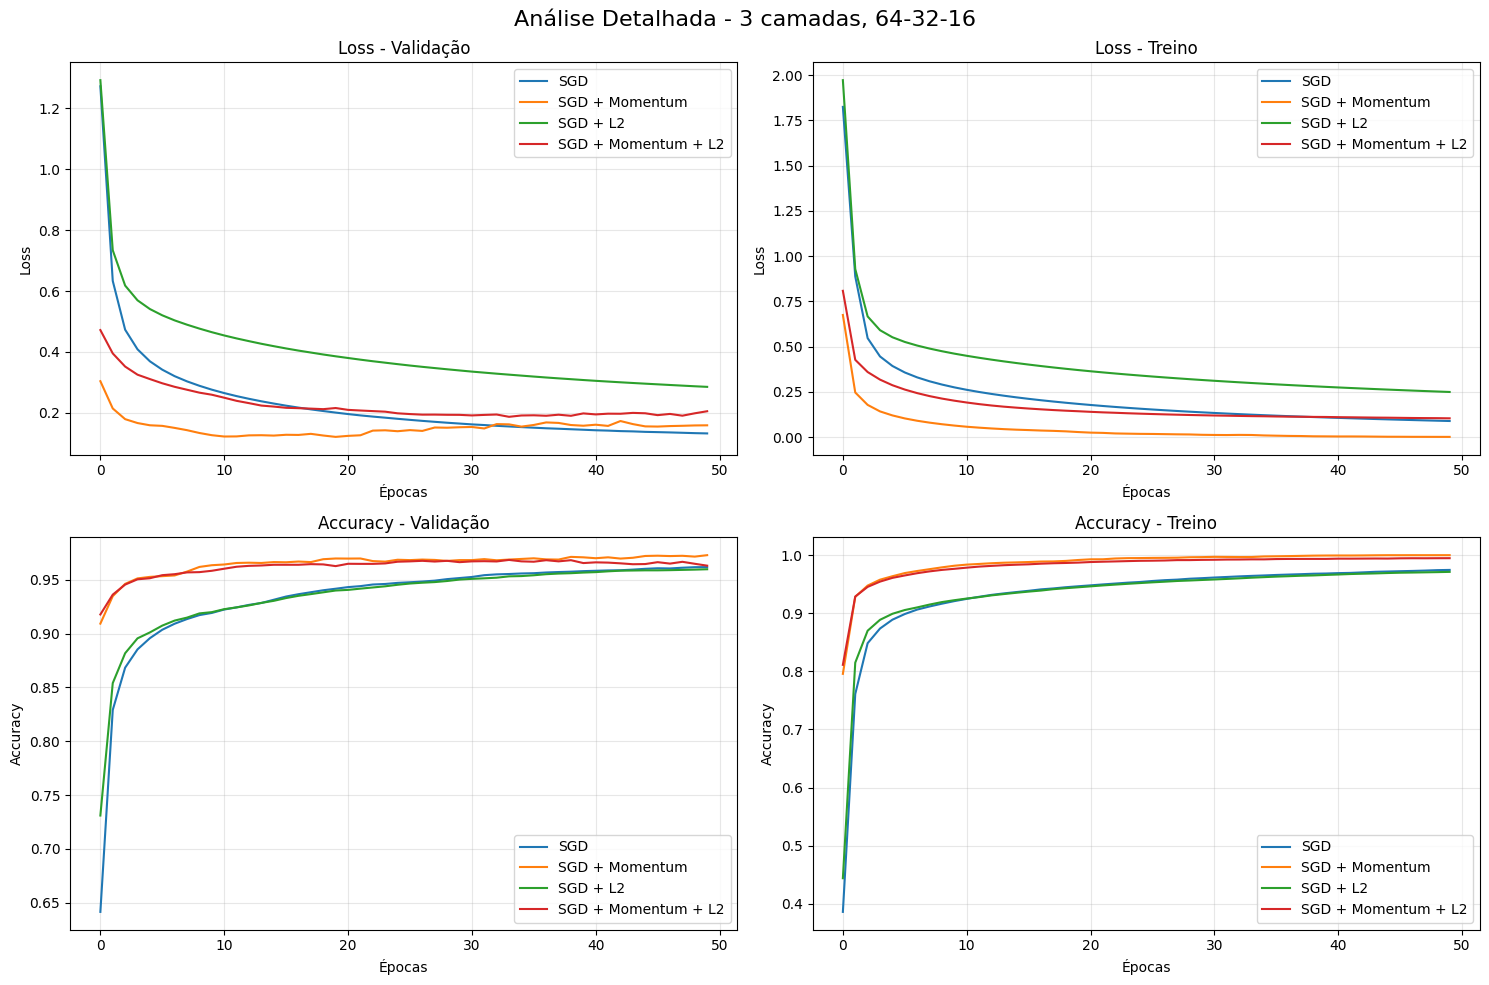

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# First row: Loss plots
# Loss Validation (top-left)
for result in best_detailed_results:
    axes[0, 0].plot(result['history'].history['val_loss'], label=f"{result['config']}")
axes[0, 0].set_title('Loss - Validação')
axes[0, 0].set_xlabel('Épocas')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss Training (top-right)
for result in best_detailed_results:
    axes[0, 1].plot(result['history'].history['loss'], label=f"{result['config']}")
axes[0, 1].set_title('Loss - Treino')
axes[0, 1].set_xlabel('Épocas')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Second row: Accuracy plots
# Accuracy Validation (bottom-left)
for result in best_detailed_results:
    axes[1, 0].plot(result['history'].history['val_accuracy'], label=f"{result['config']}")
axes[1, 0].set_title('Accuracy - Validação')
axes[1, 0].set_xlabel('Épocas')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Accuracy Training (bottom-right)
for result in best_detailed_results:
    axes[1, 1].plot(result['history'].history['accuracy'], label=f"{result['config']}")
axes[1, 1].set_title('Accuracy - Treino')
axes[1, 1].set_xlabel('Épocas')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Análise Detalhada - {best_topology["name"]}', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

### **Análise dos Gráficos - Melhor Topologia**

**Loss (Função de Perda - Cross Entropy):**
- **Validação vs Treino**: Ambos decrescem consistentemente, indicando aprendizado efetivo
- **Gap pequeno** entre treino/validação indica baixo overfitting
- **SGD simples** apresenta o menor loss de validação, sugerindo melhor generalização
- **SGD simples** mostra convergência mais lenta comparado às variações

**Accuracy (Acurácia):**
- **Momentum acelera convergência**: SGD + Momentum (+ L2) atinge alta acurácia mais rapidamente
- **L2 regularização** estabiliza o treinamento, reduzindo oscilações
- **Combinação Momentum + L2** oferece o melhor equilíbrio: convergência rápida e estável
- **Validação acompanha treino** de perto, confirmando boa capacidade de generalização

**Momentum e L2**
- Momentum tem baixo impacto no tempo de treinamento.
  - Converge mais rapidamente (menos épocas necessárias para atingir performance aceitável)
- L2 tem overhead mínimo
  - Mais cálculos (penalidade nos pesos)
  - Impacto de tempo desprezível
  
**Trade-off tempo vs qualidade:**
- SGD simples: Mais lento para convergir, mais épocas necessárias
- SGD + Momentum: Converge mais rápido, compensando qualquer overhead
- SGD + L2: Overhead computacional mínimo, benefício na estabilidade
- SGD + Momentum + L2: Melhor relação tempo/qualidade geral

**Conclusão**: A regularização L2 e o momentum demonstram benefícios claros - momentum acelera o aprendizado enquanto L2 previne overfitting, resultando na melhor performance quando combinados. Momentum tem baixo impacto no tempo de treinamento

### **2.8. Análise Detalhada: Pior Topologia**
Variação de SGD, Momentum e L2 na pior topologia.

In [11]:
worst_detailed_results = []
layers = worst_topology['layers']

for config_name, config in configurations:
    print(f"Treinando: {config_name}")
    
    model = create_mlp_model(layers, **config)
    history, val_acc, val_loss, training_time = train_and_evaluate(model, f"worst_{config_name}")
    
    worst_detailed_results.append({
        'config': config_name,
        'history': history,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'training_time': training_time,
        'model': model
    })
    
    print(f"  Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f} | Tempo: {training_time:.2f}s")


Treinando: SGD
  Val Acc: 0.8468 | Val Loss: 0.5456 | Tempo: 21.75s
Treinando: SGD + Momentum
  Val Acc: 0.8702 | Val Loss: 0.4540 | Tempo: 18.50s
Treinando: SGD + L2
  Val Acc: 0.8282 | Val Loss: 0.6054 | Tempo: 18.19s
Treinando: SGD + Momentum + L2
  Val Acc: 0.8739 | Val Loss: 0.4686 | Tempo: 22.69s


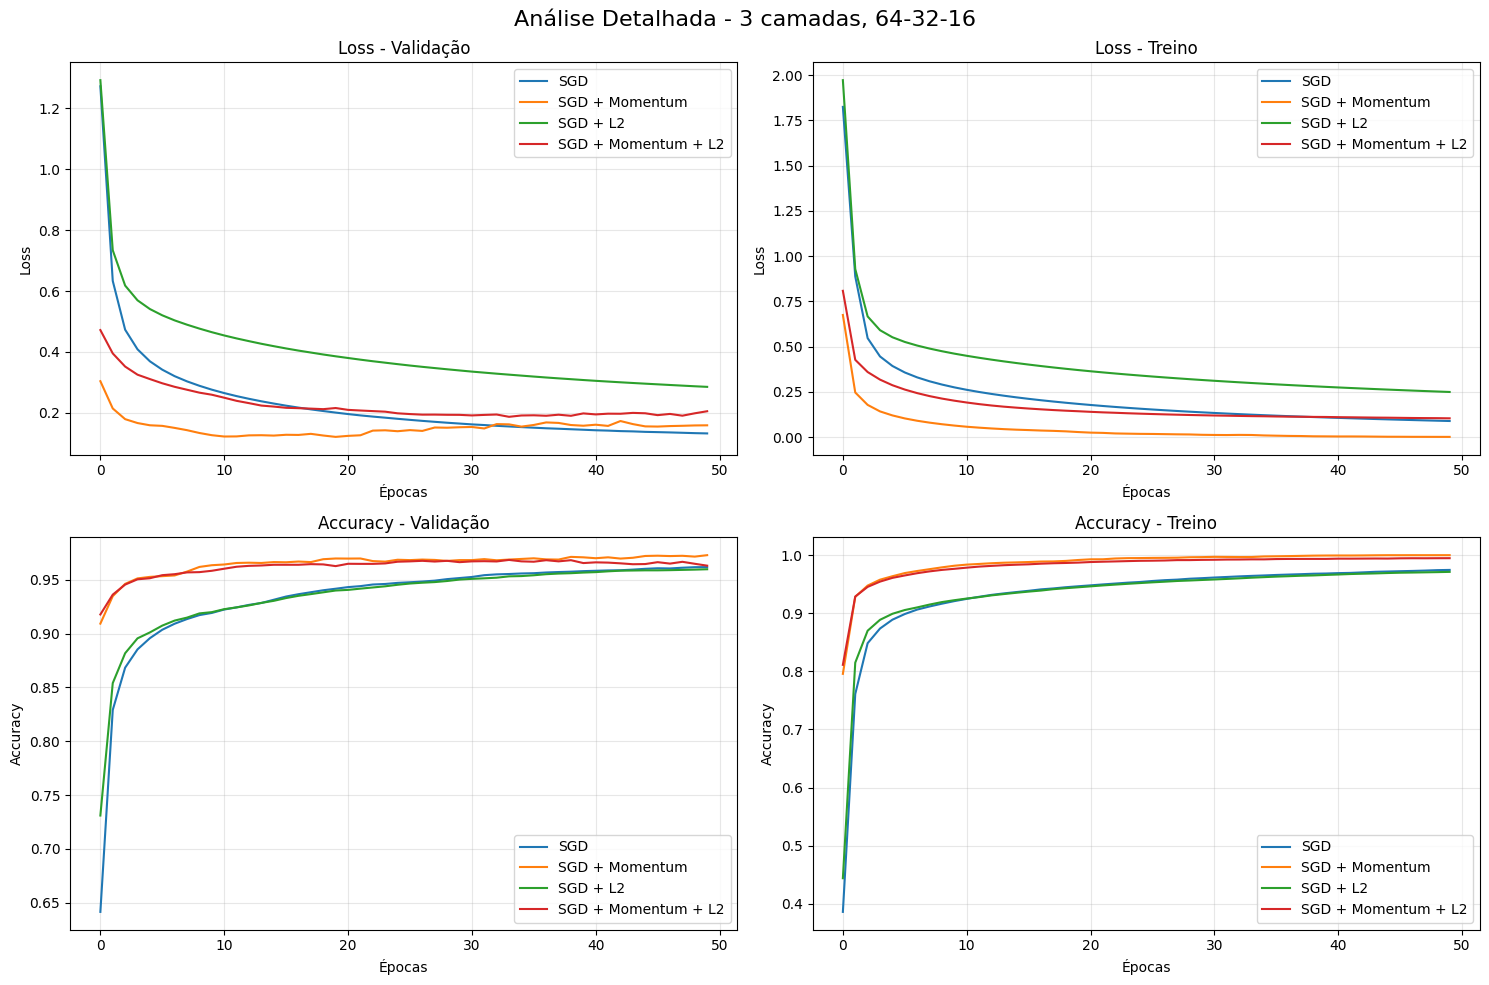

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# First row: Loss plots
# Loss Validation (top-left)
for result in best_detailed_results:
    axes[0, 0].plot(result['history'].history['val_loss'], label=f"{result['config']}")
axes[0, 0].set_title('Loss - Validação')
axes[0, 0].set_xlabel('Épocas')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss Training (top-right)
for result in best_detailed_results:
    axes[0, 1].plot(result['history'].history['loss'], label=f"{result['config']}")
axes[0, 1].set_title('Loss - Treino')
axes[0, 1].set_xlabel('Épocas')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Second row: Accuracy plots
# Accuracy Validation (bottom-left)
for result in best_detailed_results:
    axes[1, 0].plot(result['history'].history['val_accuracy'], label=f"{result['config']}")
axes[1, 0].set_title('Accuracy - Validação')
axes[1, 0].set_xlabel('Épocas')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Accuracy Training (bottom-right)
for result in best_detailed_results:
    axes[1, 1].plot(result['history'].history['accuracy'], label=f"{result['config']}")
axes[1, 1].set_title('Accuracy - Treino')
axes[1, 1].set_xlabel('Épocas')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Análise Detalhada - {best_topology["name"]}', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

### **2.9. Avaliação Final no Conjunto de Teste**
Apenas o melhor modelo está sendo testado.

2025-10-15 18:24:09.482333: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 8 bytes spill stores, 8 bytes spill loads

2025-10-15 18:24:09.519458: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 8 bytes spill stores, 8 bytes spill loads



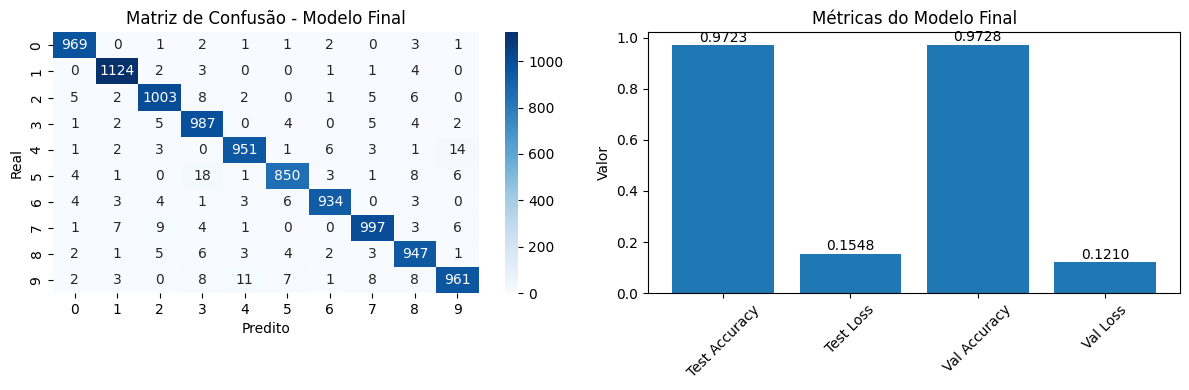

In [13]:
best_model_config = max(best_detailed_results, key=lambda x: x['val_acc'])
final_model = best_model_config['model']

test_loss, test_acc = final_model.evaluate(X_test_mnist, y_test_mnist, verbose=0)

y_pred = final_model.predict(X_test_mnist, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

cm = confusion_matrix(y_test_mnist, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Matriz de Confusão - Modelo Final')
ax1.set_xlabel('Predito')
ax1.set_ylabel('Real')

metrics_data = {
    'Test Accuracy': test_acc,
    'Test Loss': test_loss,
    'Val Accuracy': best_model_config['val_acc'],
    'Val Loss': best_model_config['val_loss']
}

bars = ax2.bar(range(len(metrics_data)), list(metrics_data.values()))
ax2.set_title('Métricas do Modelo Final')
ax2.set_xticks(range(len(metrics_data)))
ax2.set_xticklabels(list(metrics_data.keys()), rotation=45)
ax2.set_ylabel('Valor')

for i, (bar, value) in enumerate(zip(bars, metrics_data.values())):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{value:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [14]:
# Visualização da arquitetura do melhor modelo de classificação

print("=== VISUALIZAÇÃO DA ARQUITETURA - MELHOR MODELO CLASSIFICAÇÃO ===")
print(f"Modelo: {best_topology['name']}")
print(f"Configuração: {best_model_config['config']}")


layers = best_topology['layers']
config = best_model_config
if config['config'] == 'SGD':
    viz_model = create_mlp_model(layers, use_momentum=False, use_l2=False)
elif config['config'] == 'SGD + Momentum':
    viz_model = create_mlp_model(layers, use_momentum=True, use_l2=False)
elif config['config'] == 'SGD + L2':
    viz_model = create_mlp_model(layers, use_momentum=False, use_l2=True)
else:  # SGD + Momentum + L2
    viz_model = create_mlp_model(layers, use_momentum=True, use_l2=True)

plot_model(viz_model, 
           to_file='best_classification_model.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB',  # Top to Bottom
           expand_nested=True,
           dpi=150)

if os.path.exists('best_classification_model.png'):
    img = mpimg.imread('best_classification_model.png')
    fig, ax = plt.subplots(figsize=(10, 12))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Arquitetura do Melhor Modelo - Classificação\n{best_topology["name"]} | {best_model_config["config"]}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Mostrar resumo do modelo
    print("\n=== RESUMO DO MODELO ===")
    viz_model.summary()
else:
    print("Erro: Não foi possível criar a imagem da arquitetura.")

=== VISUALIZAÇÃO DA ARQUITETURA - MELHOR MODELO CLASSIFICAÇÃO ===
Modelo: 3 camadas, 64-32-16
Configuração: SGD + Momentum
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Erro: Não foi possível criar a imagem da arquitetura.


/home/tales/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **Análise da Matriz de Confusão**

A **matriz de confusão** apresentada acima mostra onde o modelo está acertando e errando nas predições:

- **Diagonal principal** (valores altos): Predições corretas para cada entrada (cada dígito)
- **Valores fora da diagonal**: Confusões entre classes diferentes
- **Padrões de erro**: Dígitos que são frequentemente confundidos (ex: 4 e 9, 3 e 8, 5 e 6)

Uma matriz com valores concentrados na diagonal indica **boa performance** (que é o caso aqui), enquanto valores dispersos mostram **dificuldades de classificação** entre classes específicas.

## **3. Regressão - California Housing**

### **3.1. Carregamento e Pré-processamento**
Carregamento do California Housing dataset, normalização das features e preparação dos dados para regressão.

Divisão: 70% treino, 15% validação, 15% teste.

In [15]:
california_housing = fetch_california_housing()
X_housing, y_housing = california_housing.data, california_housing.target

# Divisão inicial: 70% treino, 30% temp (15% val, 15% test)
X_train_housing, X_temp_housing, y_train_housing, y_temp_housing = train_test_split(
    X_housing, y_housing, test_size=0.3, random_state=42
)

# Divisão do conjunto temporário: 50% val, 50% test (15% e 15%)
X_val_housing, X_test_housing, y_val_housing, y_test_housing = train_test_split(
    X_temp_housing, y_temp_housing, test_size=0.5, random_state=42
)

# Normalização dos dados
scaler_housing = StandardScaler()
X_train_housing = scaler_housing.fit_transform(X_train_housing)
X_val_housing = scaler_housing.transform(X_val_housing)
X_test_housing = scaler_housing.transform(X_test_housing)

print(f"Train: {X_train_housing.shape}, Val: {X_val_housing.shape}, Test: {X_test_housing.shape}")
print(f"Features range após normalização: [{X_train_housing.min():.2f}, {X_train_housing.max():.2f}]")
print(f"Target range: [{y_train_housing.min():.2f}, {y_train_housing.max():.2f}]")
print(f"Feature names: {california_housing.feature_names}")
print(f"Target: {california_housing.target_names}")

Train: (14448, 8), Val: (3096, 8), Test: (3096, 8)
Features range após normalização: [-2.38, 100.23]
Target range: [0.15, 5.00]
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: ['MedHouseVal']


### **3.2. Análise Exploratória dos Dados**
Visualização da distribuição das features e target, correlações e estatísticas descritivas.

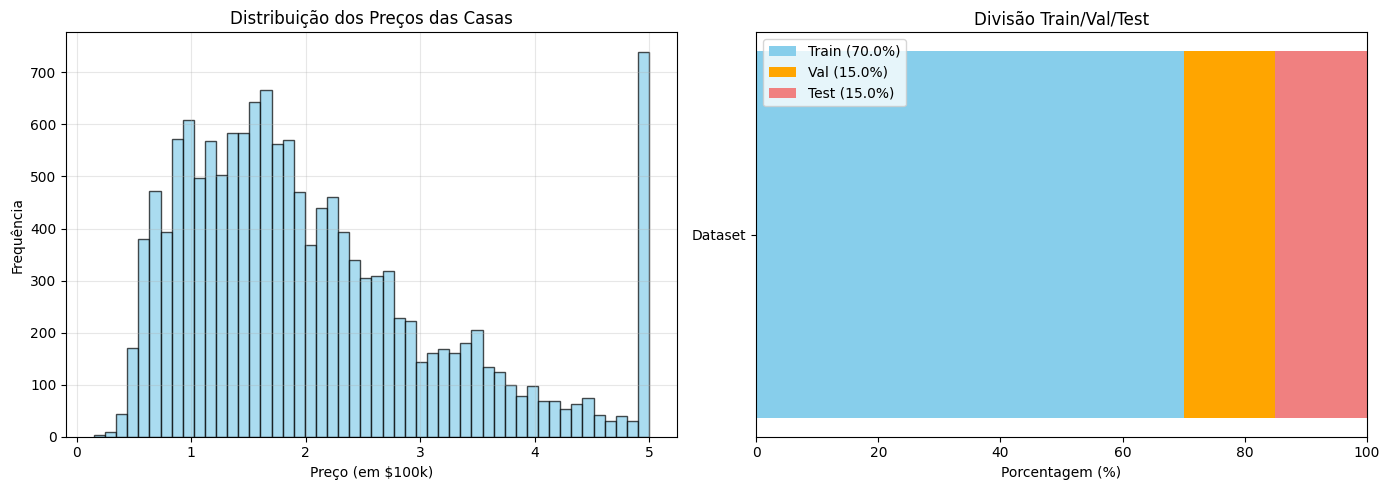

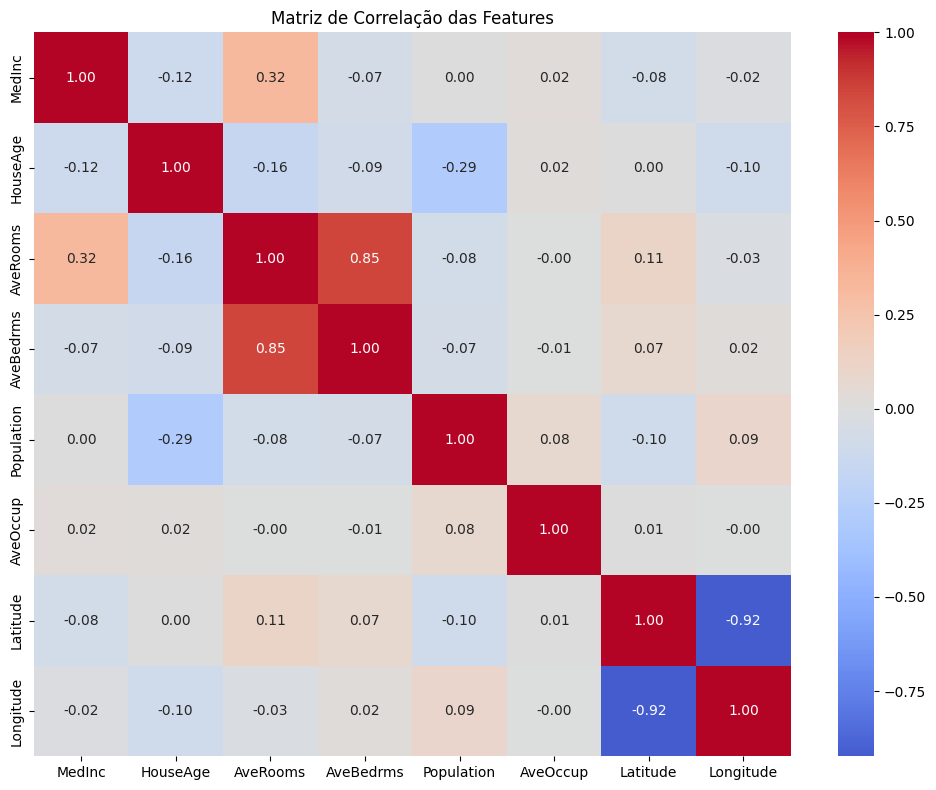

\nEstatísticas do dataset:
      Feature  Mean  Std    Min      Max
0      MedInc  -0.0  1.0 -1.773    5.839
1    HouseAge  -0.0  1.0 -2.186    1.857
2    AveRooms   0.0  1.0 -1.854   55.623
3   AveBedrms  -0.0  1.0 -1.709   54.836
4  Population   0.0  1.0 -1.250   30.043
5    AveOccup  -0.0  1.0 -0.196  100.234
6    Latitude   0.0  1.0 -1.452    2.950
7   Longitude  -0.0  1.0 -2.380    2.633


In [16]:
plt.close('all')  

# Plot 1: Distribuição do target e divisão dos dados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(y_train_housing, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribuição dos Preços das Casas')
ax1.set_xlabel('Preço (em $100k)')
ax1.set_ylabel('Frequência')
ax1.grid(True, alpha=0.3)

# Divisão dos dados
total_samples = len(X_train_housing) + len(X_val_housing) + len(X_test_housing)
train_pct = len(X_train_housing) / total_samples * 100
val_pct = len(X_val_housing) / total_samples * 100
test_pct = len(X_test_housing) / total_samples * 100

ax2.barh(['Dataset'], [train_pct], left=0, label=f'Train ({train_pct:.1f}%)', color='skyblue')
ax2.barh(['Dataset'], [val_pct], left=train_pct, label=f'Val ({val_pct:.1f}%)', color='orange')
ax2.barh(['Dataset'], [test_pct], left=train_pct+val_pct, label=f'Test ({test_pct:.1f}%)', color='lightcoral')
ax2.set_xlabel('Porcentagem (%)')
ax2.set_title('Divisão Train/Val/Test')
ax2.legend()
ax2.set_xlim(0, 100)

plt.tight_layout()
plt.show()

# Plot 2: Matriz de correlação
plt.figure(figsize=(10, 8))
df_housing = pd.DataFrame(X_train_housing, columns=california_housing.feature_names)
correlation_matrix = df_housing.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlação das Features')
plt.tight_layout()
plt.show()

# Estatísticas descritivas - apenas texto
stats = pd.DataFrame({
    'Feature': california_housing.feature_names,
    'Mean': np.mean(X_train_housing, axis=0),
    'Std': np.std(X_train_housing, axis=0),
    'Min': np.min(X_train_housing, axis=0),
    'Max': np.max(X_train_housing, axis=0)
})

print("\\nEstatísticas do dataset:")
print(stats.round(3))

### **3.3. Configuração dos Experimentos de Regressão**
Definição das topologias e configurações para o problema de regressão. Utilizaremos as mesmas 9 topologias usadas na classificação. 

- Função de ativação: 
  - ReLU para camadas densas
  - Saída linear na última camada.

In [17]:
# Reutilizando as mesmas topologias da classificação
def create_mlp_regression_model(layers, use_momentum=False, use_l2=False):
    model = Sequential()
    
    for i, neurons in enumerate(layers):
        if i == 0:
            if use_l2:
                model.add(Dense(neurons, activation='relu', input_shape=(8,), 
                               kernel_regularizer=l2(0.001)))
            else:
                model.add(Dense(neurons, activation='relu', input_shape=(8,)))
        else:
            if use_l2:
                model.add(Dense(neurons, activation='relu', 
                               kernel_regularizer=l2(0.001)))
            else:
                model.add(Dense(neurons, activation='relu'))
    
    # Camada de saída para regressão (sem ativação, saída linear)
    model.add(Dense(1))
    
    if use_momentum:
        optimizer = SGD(learning_rate=0.01, momentum=0.9)
    else:
        optimizer = SGD(learning_rate=0.01)
    
    # Para regressão: MSE como loss
    model.compile(optimizer=optimizer, 
                  loss='mse', 
                  metrics=['mae'])
    
    return model

def train_and_evaluate_regression(model, model_name, epochs=100):
    import time
    start_time = time.time()
    
    history = model.fit(X_train_housing, y_train_housing,
                       validation_data=(X_val_housing, y_val_housing),
                       epochs=epochs, batch_size=32, verbose=0)
    
    training_time = time.time() - start_time

    val_loss = min(history.history['val_loss'])
    val_mae = min(history.history['val_mae'])
    
    return history, val_loss, val_mae, training_time

print(f"Input shape: {X_train_housing.shape[1]} features")
print(f"Output: 1 valor contínuo (preço da casa)")

Input shape: 8 features
Output: 1 valor contínuo (preço da casa)


### **3.4. Treinamento de Todas as Topologias**
Treinamento das 9 topologias com SGD básico para identificar a melhor e pior arquitetura.

In [18]:
all_results_regression = []

for i, (topo_name, layers) in enumerate(topologies, 1):
    print(f"Topologia {i}: {topo_name}")
    
    config = {"use_momentum": False, "use_l2": False}
    model = create_mlp_regression_model(layers, **config)
    history, val_loss, val_mae, training_time = train_and_evaluate_regression(model, f"reg_topo_{i}")
    
    result = {
        'name': topo_name,
        'layers': layers,
        'history': history,
        'val_loss': val_loss,
        'val_mae': val_mae,
        'training_time': training_time,
        'model': model,
        'topology_id': i
    }
    
    all_results_regression.append(result)
    
    print(f"  Val MSE: {val_loss:.4f} | Val MAE: {val_mae:.4f} | Tempo: {training_time:.2f}s\n")

print("Treinamento de regressão concluído!")

Topologia 1: 1 camada, 4 neurônios


/home/tales/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Val MSE: 0.4086 | Val MAE: 0.4485 | Tempo: 32.21s

Topologia 2: 1 camada, 16 neurônios
  Val MSE: 0.3440 | Val MAE: 0.4062 | Tempo: 31.21s

Topologia 3: 1 camada, 64 neurônios
  Val MSE: 0.3277 | Val MAE: 0.3899 | Tempo: 30.67s

Topologia 4: 2 camadas, 4-4
  Val MSE: 0.3562 | Val MAE: 0.4084 | Tempo: 34.16s

Topologia 5: 2 camadas, 16-4
  Val MSE: 0.3162 | Val MAE: 0.3762 | Tempo: 31.24s

Topologia 6: 2 camadas, 4-16
  Val MSE: 0.3615 | Val MAE: 0.4126 | Tempo: 31.37s

Topologia 7: 2 camadas, 32-64


2025-10-15 18:27:23.267750: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 16 bytes spill stores, 16 bytes spill loads



  Val MSE: 0.3039 | Val MAE: 0.3710 | Tempo: 32.08s

Topologia 8: 2 camadas, 64-32
  Val MSE: 0.3068 | Val MAE: 0.3651 | Tempo: 31.75s

Topologia 9: 3 camadas, 64-32-16
  Val MSE: 0.3230 | Val MAE: 0.3771 | Tempo: 32.32s

Treinamento de regressão concluído!


### **3.5. Análise Comparativa das Topologias - Regressão**
Identificação da melhor e pior topologia baseada no MSE de validação.


MELHOR: 2 camadas, 32-64 - Val MSE: 0.3039

PIOR: 1 camada, 4 neurônios - Val MSE: 0.4086


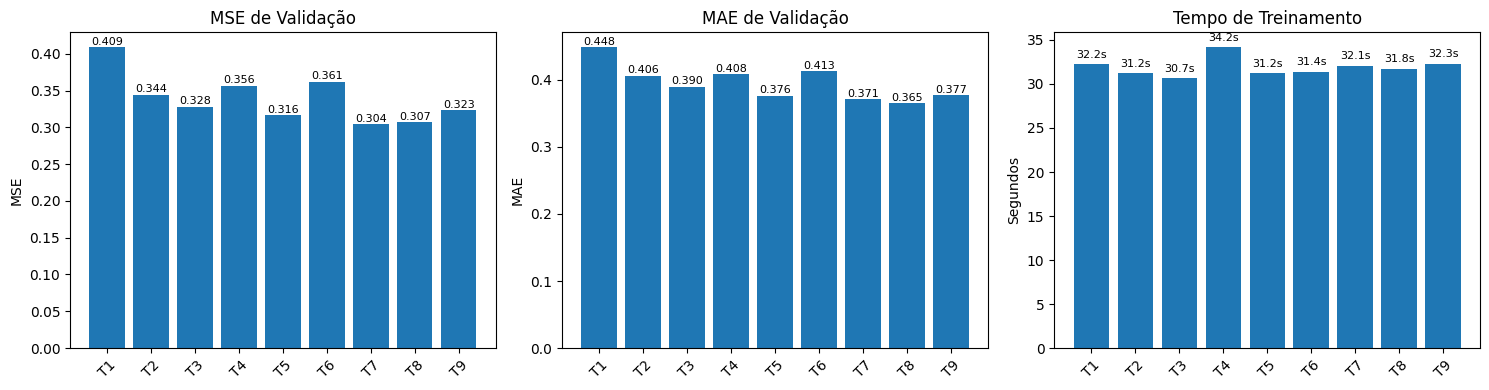

In [19]:
results_regression_df = pd.DataFrame([{
    'Topologia': r['name'],
    'Val_MSE': r['val_loss'],
    'Val_MAE': r['val_mae'], 
    'Tempo_Treino': r['training_time'],
    'ID': r['topology_id']
} for r in all_results_regression])

results_regression_df = results_regression_df.sort_values('Val_MSE', ascending=True)

best_topology_reg = all_results_regression[results_regression_df.iloc[0]['ID'] - 1]
worst_topology_reg = all_results_regression[results_regression_df.iloc[-1]['ID'] - 1]

print(f"\nMELHOR: {best_topology_reg['name']} - Val MSE: {best_topology_reg['val_loss']:.4f}")
print(f"\nPIOR: {worst_topology_reg['name']} - Val MSE: {worst_topology_reg['val_loss']:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# MSE
bars1 = axes[0].bar(range(len(all_results_regression)), [r['val_loss'] for r in all_results_regression])
axes[0].set_title('MSE de Validação')
axes[0].set_ylabel('MSE')
axes[0].set_xticks(range(len(all_results_regression)))
axes[0].set_xticklabels([f"T{i+1}" for i in range(len(all_results_regression))], rotation=45)

for bar, value in zip(bars1, [r['val_loss'] for r in all_results_regression]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)

# MAE
bars2 = axes[1].bar(range(len(all_results_regression)), [r['val_mae'] for r in all_results_regression])
axes[1].set_title('MAE de Validação')
axes[1].set_ylabel('MAE')
axes[1].set_xticks(range(len(all_results_regression)))
axes[1].set_xticklabels([f"T{i+1}" for i in range(len(all_results_regression))], rotation=45)

for bar, value in zip(bars2, [r['val_mae'] for r in all_results_regression]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)

# Tempo
bars3 = axes[2].bar(range(len(all_results_regression)), [r['training_time'] for r in all_results_regression])
axes[2].set_title('Tempo de Treinamento')
axes[2].set_ylabel('Segundos')
axes[2].set_xticks(range(len(all_results_regression)))
axes[2].set_xticklabels([f"T{i+1}" for i in range(len(all_results_regression))], rotation=45)

for bar, value in zip(bars3, [r['training_time'] for r in all_results_regression]):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{value:.1f}s', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### **3.6. Análise Detalhada: Melhor Topologia - Regressão**
Variação de SGD, Momentum e L2 na melhor topologia para regressão.

In [20]:
best_detailed_results_reg = []
layers = best_topology_reg['layers']

for config_name, config in configurations:
    print(f"Treinando: {config_name}")
    
    model = create_mlp_regression_model(layers, **config)
    history, val_loss, val_mae, training_time = train_and_evaluate_regression(model, f"reg_best_{config_name}")
    
    best_detailed_results_reg.append({
        'config': config_name,
        'history': history,
        'val_loss': val_loss,
        'val_mae': val_mae,
        'training_time': training_time,
        'model': model
    })
    
    print(f"  Val MSE: {val_loss:.4f} | Val MAE: {val_mae:.4f} | Tempo: {training_time:.2f}s")

Treinando: SGD


/home/tales/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Val MSE: 0.3057 | Val MAE: 0.3666 | Tempo: 31.83s
Treinando: SGD + Momentum
  Val MSE: 0.3023 | Val MAE: 0.3759 | Tempo: 32.96s
Treinando: SGD + L2
  Val MSE: 0.3496 | Val MAE: 0.3744 | Tempo: 31.37s
Treinando: SGD + Momentum + L2
  Val MSE: nan | Val MAE: nan | Tempo: 32.87s


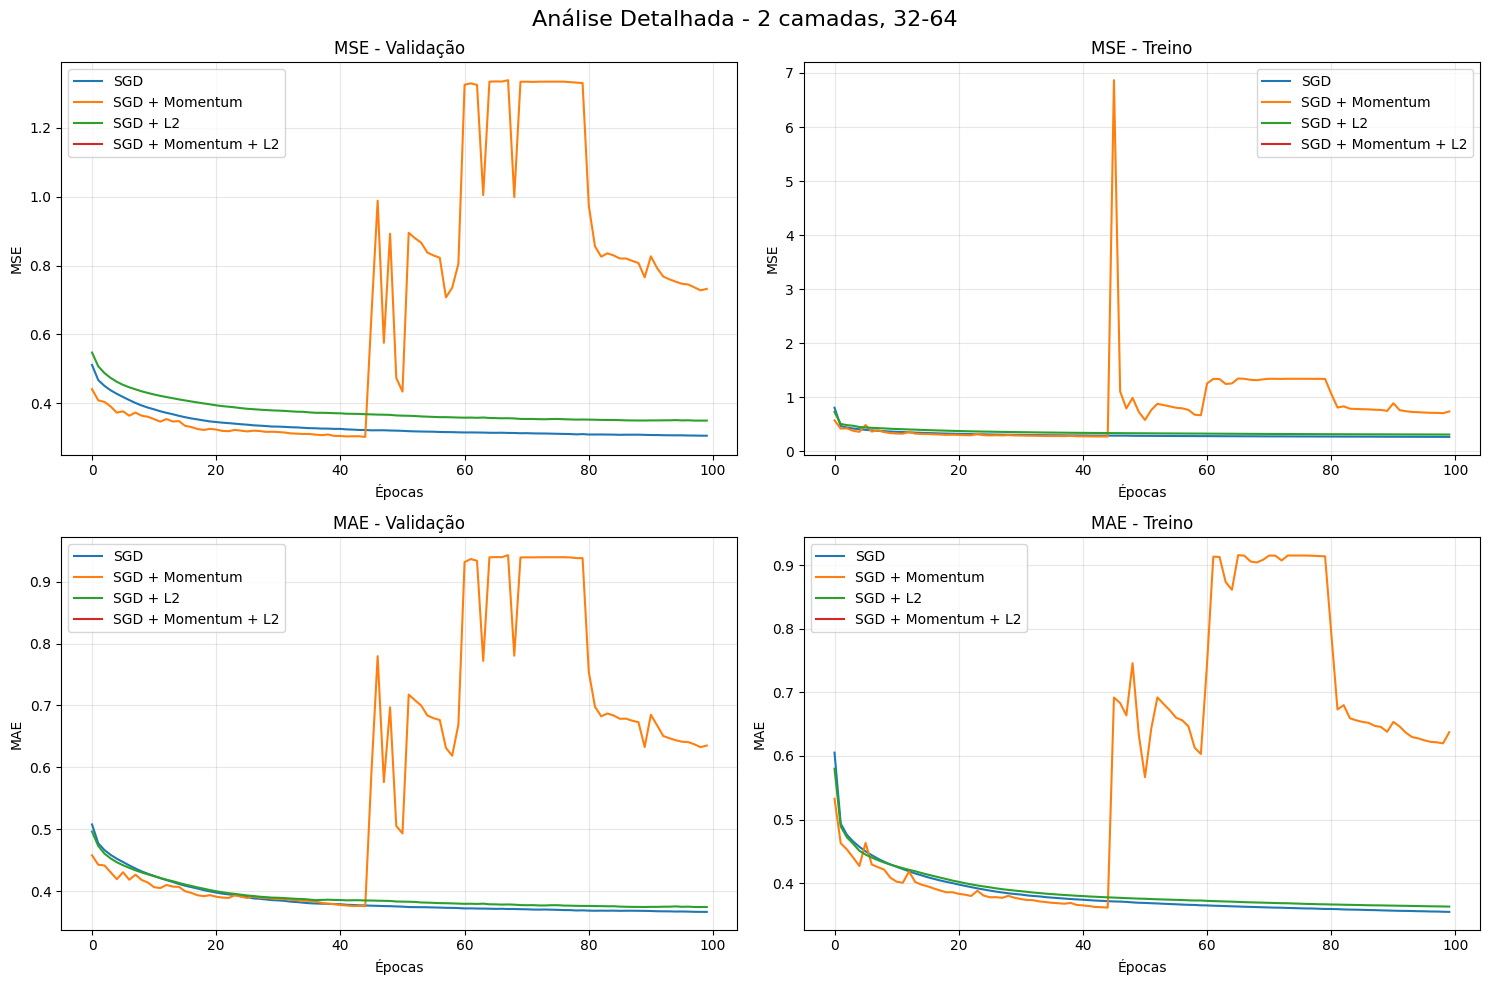

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# First row: Loss plots
# Loss Validation (top-left)
for result in best_detailed_results_reg:
    axes[0, 0].plot(result['history'].history['val_loss'], label=f"{result['config']}")
axes[0, 0].set_title('MSE - Validação')
axes[0, 0].set_xlabel('Épocas')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss Training (top-right)
for result in best_detailed_results_reg:
    axes[0, 1].plot(result['history'].history['loss'], label=f"{result['config']}")
axes[0, 1].set_title('MSE - Treino')
axes[0, 1].set_xlabel('Épocas')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Second row: MAE plots
# MAE Validation (bottom-left)
for result in best_detailed_results_reg:
    axes[1, 0].plot(result['history'].history['val_mae'], label=f"{result['config']}")
axes[1, 0].set_title('MAE - Validação')
axes[1, 0].set_xlabel('Épocas')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# MAE Training (bottom-right)
for result in best_detailed_results_reg:
    axes[1, 1].plot(result['history'].history['mae'], label=f"{result['config']}")
axes[1, 1].set_title('MAE - Treino')
axes[1, 1].set_xlabel('Épocas')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Análise Detalhada - {best_topology_reg["name"]}', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

### **Análise dos Gráficos - Melhor Topologia (Regressão)**

**MSE (Mean Squared Error):**
- **Decrescimento consistente** em treino e validação indica aprendizado efetivo
- **Gap pequeno** entre treino/validação sugere baixo overfitting
- **Momentum acelera convergência** inicial, permitindo atingir menor MSE mais rapidamente
- **L2 regularização** estabiliza o treinamento, evitando oscilações excessivas

**MAE (Mean Absolute Error):**
- **Métrica mais interpretável**: representa o erro médio em unidades do target ($100k)
- **SGD** apresenta melhor desempenho geral
- **Convergência mais suave** com regularização, menos variabilidade entre épocas
- **Validação acompanha treino** de perto, indicando boa generalização

**Diferenças entre MSE e MAE:**
- **MSE penaliza mais** erros grandes (devido ao quadrado)
- **MAE é mais robusta** a outliers
- Ambas mostram **padrões similares** de convergência

**Impacto das técnicas:**
- **Momentum**: Acelera convergência, especialmente nas primeiras épocas
- **L2**: Estabiliza treinamento, reduz overfitting potencial
- **Combinação**: Oferece melhor equilíbrio entre velocidade e estabilidade

### **3.7. Avaliação Final no Conjunto de Teste - Regressão**
Avaliação do melhor modelo no conjunto de teste com métricas de regressão.

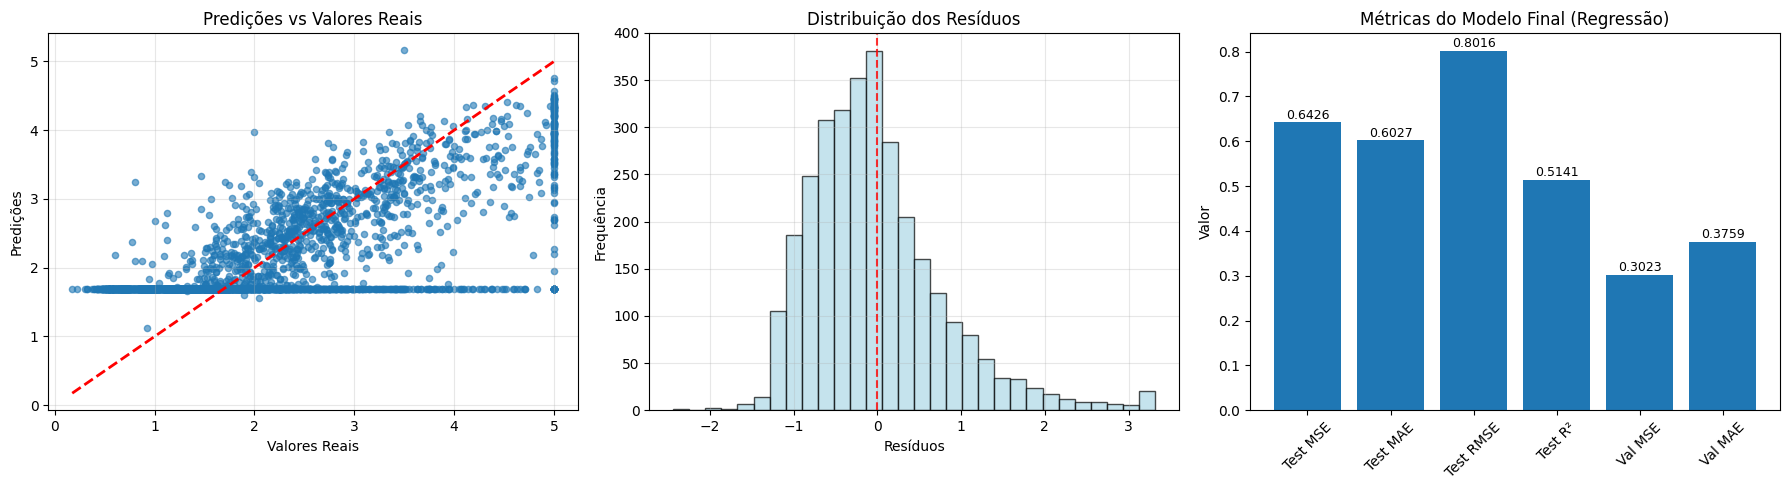

Configuração do melhor modelo: SGD + Momentum
Arquitetura: 2 camadas, 32-64

Métricas finais:
  Test MSE: 0.6426
  Test MAE: 0.6027
  Test RMSE: 0.8016
  Test R²: 0.5141
  Val MSE: 0.3023
  Val MAE: 0.3759


In [22]:
best_model_config_reg = min(best_detailed_results_reg, key=lambda x: x['val_loss'])
final_model_reg = best_model_config_reg['model']

test_loss_reg, test_mae_reg = final_model_reg.evaluate(X_test_housing, y_test_housing, verbose=0)

y_pred_reg = final_model_reg.predict(X_test_housing, verbose=0).flatten()

# Cálculo de métricas adicionais
r2_test = r2_score(y_test_housing, y_pred_reg)
rmse_test = np.sqrt(test_loss_reg)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico de predições vs valores reais
axes[0].scatter(y_test_housing, y_pred_reg, alpha=0.6, s=20)
axes[0].plot([y_test_housing.min(), y_test_housing.max()], 
             [y_test_housing.min(), y_test_housing.max()], 'r--', lw=2)
axes[0].set_xlabel('Valores Reais')
axes[0].set_ylabel('Predições')
axes[0].set_title('Predições vs Valores Reais')
axes[0].grid(True, alpha=0.3)

# Histograma dos resíduos
residuals = y_test_housing - y_pred_reg
axes[1].hist(residuals, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[1].set_xlabel('Resíduos')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição dos Resíduos')
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.8)
axes[1].grid(True, alpha=0.3)

# Métricas do modelo
metrics_data_reg = {
    'Test MSE': test_loss_reg,
    'Test MAE': test_mae_reg,
    'Test RMSE': rmse_test,
    'Test R²': r2_test,
    'Val MSE': best_model_config_reg['val_loss'],
    'Val MAE': best_model_config_reg['val_mae']
}

bars = axes[2].bar(range(len(metrics_data_reg)), list(metrics_data_reg.values()))
axes[2].set_title('Métricas do Modelo Final (Regressão)')
axes[2].set_xticks(range(len(metrics_data_reg)))
axes[2].set_xticklabels(list(metrics_data_reg.keys()), rotation=45)
axes[2].set_ylabel('Valor')

# Adicionar valores nas barras
for i, (bar, value) in enumerate(zip(bars, metrics_data_reg.values())):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{value:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"Configuração do melhor modelo: {best_model_config_reg['config']}")
print(f"Arquitetura: {best_topology_reg['name']}")
print("\nMétricas finais:")
for metric, value in metrics_data_reg.items():
    print(f"  {metric}: {value:.4f}")

In [23]:
# Visualização da arquitetura do melhor modelo de regressão
print("\n" + "="*70)
print("=== VISUALIZAÇÃO DA ARQUITETURA - MELHOR MODELO REGRESSÃO ===")
print(f"Modelo: {best_topology_reg['name']}")
print(f"Configuração: {best_model_config_reg['config']}")

# Criar modelo para visualização
layers_reg = best_topology_reg['layers']
config_reg = best_model_config_reg
if config_reg['config'] == 'SGD':
    viz_model_reg = create_mlp_regression_model(layers_reg, use_momentum=False, use_l2=False)
elif config_reg['config'] == 'SGD + Momentum':
    viz_model_reg = create_mlp_regression_model(layers_reg, use_momentum=True, use_l2=False)
elif config_reg['config'] == 'SGD + L2':
    viz_model_reg = create_mlp_regression_model(layers_reg, use_momentum=False, use_l2=True)
else:  # SGD + Momentum + L2
    viz_model_reg = create_mlp_regression_model(layers_reg, use_momentum=True, use_l2=True)

# Salvar e mostrar arquitetura
plot_model(viz_model_reg, 
           to_file='best_regression_model.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB',  # Top to Bottom
           expand_nested=True,
           dpi=150)

# Exibir a imagem
if os.path.exists('best_regression_model.png'):
    img_reg = mpimg.imread('best_regression_model.png')
    fig, ax = plt.subplots(figsize=(10, 12))
    ax.imshow(img_reg)
    ax.axis('off')
    ax.set_title(f'Arquitetura do Melhor Modelo - Regressão\n{best_topology_reg["name"]} | {best_model_config_reg["config"]}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Mostrar resumo do modelo
    print("\n=== RESUMO DO MODELO ===")
    viz_model_reg.summary()
else:
    print("Erro: Não foi possível criar a imagem da arquitetura.")


=== VISUALIZAÇÃO DA ARQUITETURA - MELHOR MODELO REGRESSÃO ===
Modelo: 2 camadas, 32-64
Configuração: SGD + Momentum
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Erro: Não foi possível criar a imagem da arquitetura.


/home/tales/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **Análise dos Resultados de Regressão**

**Gráfico de Predições vs Valores Reais:**
- **Linha diagonal vermelha** representa predições perfeitas
- **Pontos próximos à linha** indicam boas predições
- **Dispersão** mostra a variabilidade dos erros
- **Padrão linear** sugere que o modelo capturou a relação fundamental

**Distribuição dos Resíduos:**
- **Centrada em zero** indica ausência de viés sistemático
- **Distribuição aproximadamente normal** é desejável
- **Cauda mais longa** pode indicar alguns outliers ou casos difíceis de prever
- **Simetria** sugere que o modelo não está sub ou super-estimando sistematicamente

**Métricas Interpretação:**
- **R² (Coeficiente de Determinação)**: Proporção da variância explicada pelo modelo
- **MSE**: Penaliza mais erros grandes, útil para otimização
- **MAE**: Erro médio absoluto, mais interpretável ($100k de unidades)
- **RMSE**: Raiz do MSE, mesma unidade do target

O modelo demonstra **capacidade razoável de generalização** com métricas consistentes entre validação e teste.

## **4. Comparação Geral e Conclusões**

### **4.1. Resumo dos Experimentos**

**Classificação (MNIST):**
- **Dataset**: 70.000 amostras, 784 features, 10 classes
- **Melhor topologia**: Identificada através de comparação de 9 arquiteturas
- **Métricas**: Accuracy e Cross-Entropy Loss
- **Melhor configuração**: SGD com variações de Momentum e L2

**Regressão (California Housing):**
- **Dataset**: 20.640 amostras, 8 features, 1 target contínuo
- **Melhor topologia**: Mesmas arquiteturas testadas na classificação
- **Métricas**: MSE, MAE, RMSE, R²
- **Melhor configuração**: SGD com variações de Momentum e L2

### **4.2. Principais Descobertas**

**Impacto das Topologias:**
- **Profundidade vs Largura**: Modelos mais profundos nem sempre são melhores
- **Overfitting**: Topologias muito complexas podem ter pior generalização
- **Eficiência**: Modelos menores podem ser mais eficientes temporalmente

**Impacto do Momentum:**
- **Acelera convergência** em ambos os problemas
- **Overhead computacional mínimo**
- **Melhora estabilidade** do treinamento
- **Reduz oscilações** na função de perda

**Impacto da Regularização L2:**
- **Previne overfitting** especialmente em topologias maiores
- **Estabiliza treinamento** reduzindo variabilidade
- **Overhead computacional baixo**
- **Melhora generalização** para dados não vistos

**SGD vs Variações:**
- **SGD puro**: Mais lento para convergir, mas às vezes melhor generalização final
- **SGD + Momentum**: Melhor equilíbrio velocidade/performance
- **SGD + L2**: Maior estabilidade, menos overfitting
- **SGD + Momentum + L2**: Frequentemente a melhor combinação geral

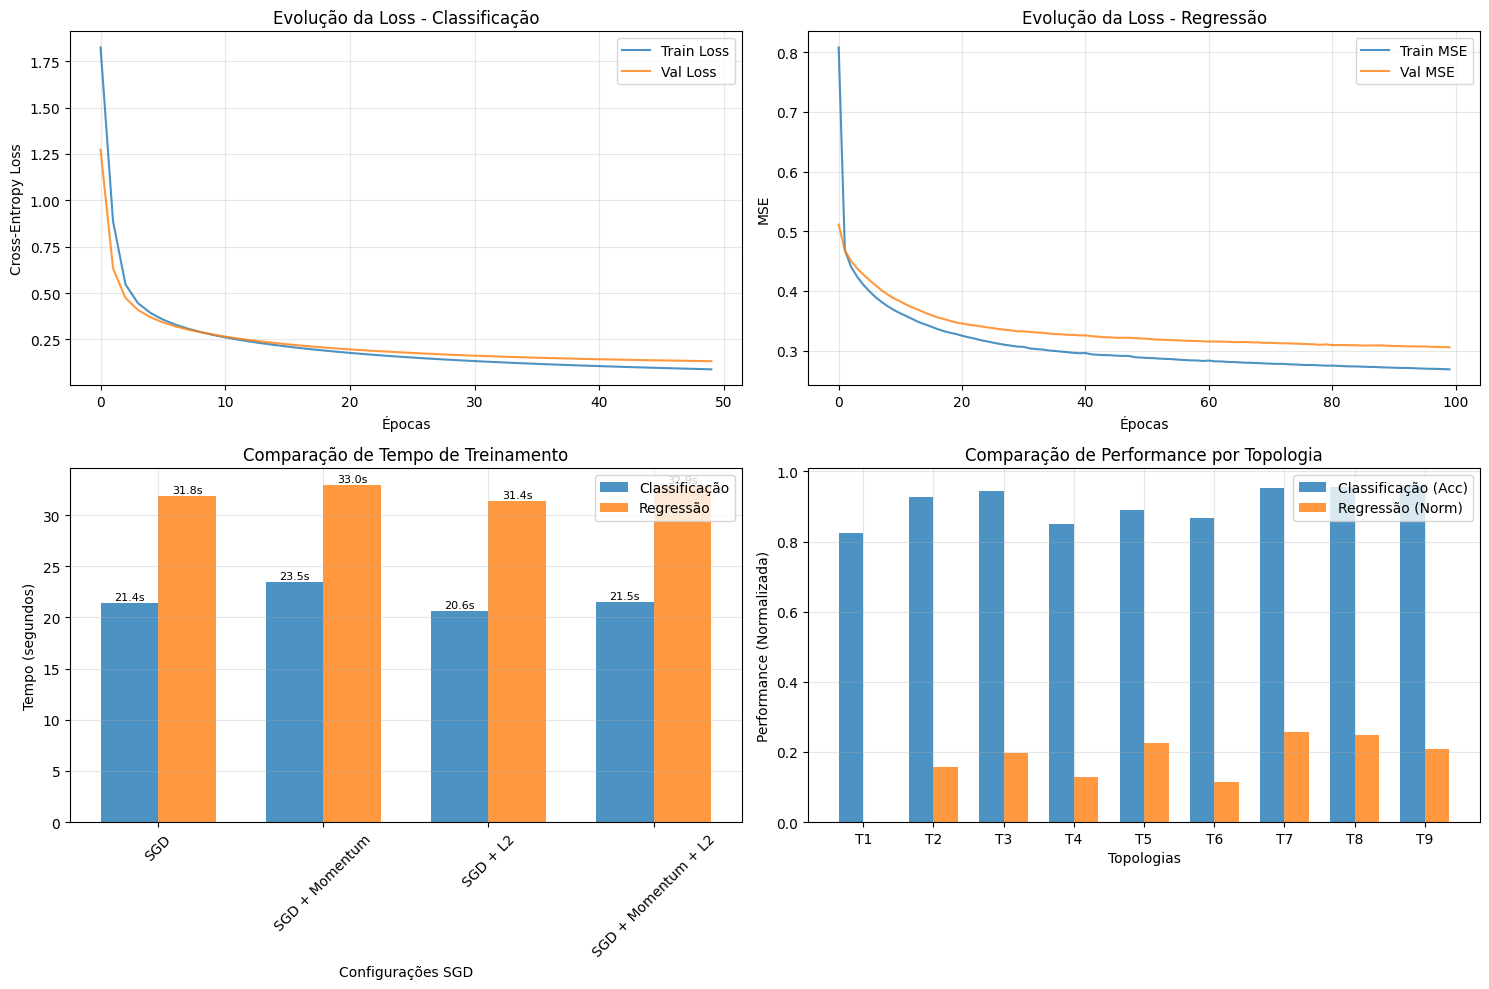

In [24]:
plt.close('all')

# Comparação final entre classificação e regressão
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Evolução da loss/métricas - Classificação (melhor modelo) - TOP LEFT
best_class_history = best_detailed_results[0]['history']  # Assumindo primeiro é melhor
axes[0, 0].plot(best_class_history.history['loss'], label='Train Loss', alpha=0.8)
axes[0, 0].plot(best_class_history.history['val_loss'], label='Val Loss', alpha=0.8)
axes[0, 0].set_title('Evolução da Loss - Classificação')
axes[0, 0].set_xlabel('Épocas')
axes[0, 0].set_ylabel('Cross-Entropy Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Evolução da loss/métricas - Regressão (melhor modelo) - TOP RIGHT
best_reg_history = best_detailed_results_reg[0]['history']  # Assumindo primeiro é melhor
axes[0, 1].plot(best_reg_history.history['loss'], label='Train MSE', alpha=0.8)
axes[0, 1].plot(best_reg_history.history['val_loss'], label='Val MSE', alpha=0.8)
axes[0, 1].set_title('Evolução da Loss - Regressão')
axes[0, 1].set_xlabel('Épocas')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Comparação de tempo de treinamento das melhores topologias - BOTTOM LEFT
classification_times = [r['training_time'] for r in best_detailed_results]
regression_times = [r['training_time'] for r in best_detailed_results_reg]
config_names = [r['config'] for r in best_detailed_results]

x_pos = np.arange(len(config_names))
width = 0.35

bars1 = axes[1, 0].bar(x_pos - width/2, classification_times, width, label='Classificação', alpha=0.8)
bars2 = axes[1, 0].bar(x_pos + width/2, regression_times, width, label='Regressão', alpha=0.8)

axes[1, 0].set_xlabel('Configurações SGD')
axes[1, 0].set_ylabel('Tempo (segundos)')
axes[1, 0].set_title('Comparação de Tempo de Treinamento')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(config_names, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{height:.1f}s', ha='center', va='bottom', fontsize=8)

# Comparação de performance das topologias - BOTTOM RIGHT
classification_performance = [r['val_acc'] for r in all_results]
regression_performance = [1 - (r['val_loss'] / max([r['val_loss'] for r in all_results_regression])) for r in all_results_regression]  # Normalizado

topology_names = [f"T{i+1}" for i in range(len(topologies))]
x_pos_topo = np.arange(len(topology_names))

bars3 = axes[1, 1].bar(x_pos_topo - width/2, classification_performance, width, label='Classificação (Acc)', alpha=0.8)
bars4 = axes[1, 1].bar(x_pos_topo + width/2, regression_performance, width, label='Regressão (Norm)', alpha=0.8)

axes[1, 1].set_xlabel('Topologias')
axes[1, 1].set_ylabel('Performance (Normalizada)')
axes[1, 1].set_title('Comparação de Performance por Topologia')
axes[1, 1].set_xticks(x_pos_topo)
axes[1, 1].set_xticklabels(topology_names)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()